### Evaluation des modéles

##### 1. Chargement de modéles

In [1]:
import joblib as jb

lr_model = jb.load('../models/lr_model.pkl')
rf_model = jb.load('../models/rf_model.pkl')
xgb_model = jb.load('../models/xgb_model.pkl')
svm_model = jb.load('../models/svm_model.pkl')
knn_model = jb.load('../models/knn_model.pkl')

##### 2. Chargement de données et extraction de labels et d'embeddings d'entrainement et de test

In [2]:
import chromadb

client = chromadb.PersistentClient(path='../data/chromaDB')

train_collection = client.get_collection(name='train_collection')
test_collection = client.get_collection(name='test_collection')

all_train_metadatas = train_collection.get(include=["metadatas", "embeddings"])
all_test_metadatas = test_collection.get(include=["metadatas", "embeddings"])

train_labels = [metadata['label'] for metadata in all_train_metadatas['metadatas']]
labels = [metadata['label'] for metadata in all_test_metadatas['metadatas']]

train_embeddings = [emb for emb in all_train_metadatas['embeddings']]
embeddings = [emb for emb in all_test_metadatas['embeddings']]

print(len(train_labels))
print(len(train_embeddings))
print(len(labels))
print(len(embeddings))

120000
120000
7600
7600


##### 3. Définer features et target

In [3]:
import numpy as np

X_train = np.array(train_embeddings)
y_train = np.array(train_labels)

X_test = np.array(embeddings)
y_test = np.array(labels)

##### 4. Évaluer les performances des modèles.

In [4]:
acc_list = {}

##### 4.1. Logistic Regression

In [5]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = lr_model.predict(X_test)

acc_list['Logistic Regression'] = (accuracy_score(y_test, y_pred))

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8882894736842105
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1900
           1       0.95      0.96      0.95      1900
           2       0.84      0.85      0.85      1900
           3       0.86      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



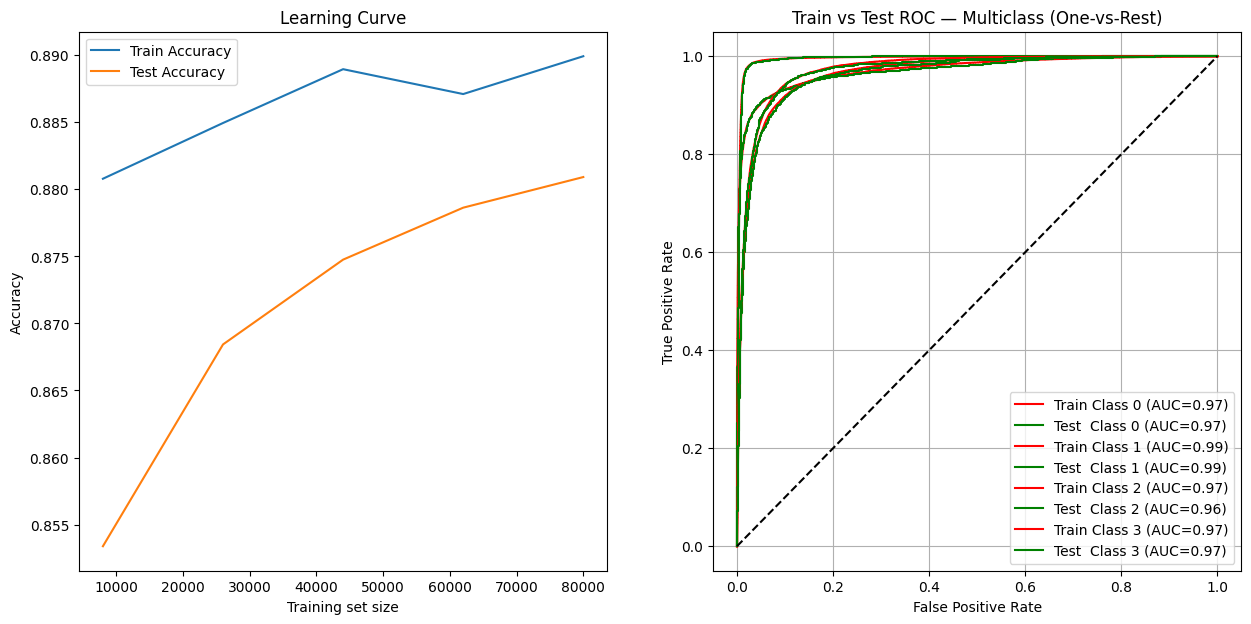

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15, 7))

#### 1.

plt.subplot(1, 2, 1)
train_sizes, train_scores, test_scores = learning_curve(
    lr_model, 
    X_train, y_train, 
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Train Accuracy')
plt.plot(train_sizes, test_mean, label='Test Accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()

#### 2.

classes = np.unique(y_train)
n_classes = len(classes)

# Binarize train and test labels
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

# Get predicted probabilities
y_train_scores = lr_model.predict_proba(X_train)
y_test_scores  = lr_model.predict_proba(X_test)

plt.subplot(1, 2, 2)
for i in range(n_classes):
    # ROC for train
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_scores[:, i])
    auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color='red', linestyle='-', label=f"Train Class {classes[i]} (AUC={auc_train:.2f})")
    
    # ROC for test
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_scores[:, i])
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color="green", linestyle='-', label=f"Test  Class {classes[i]} (AUC={auc_test:.2f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC — Multiclass (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

##### 4.2. Random Forest

In [6]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_rf = rf_model.predict(X_test)

acc_list['Random Forest'] = (accuracy_score(y_test, y_pred_rf))

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8809210526315789
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1900
           1       0.93      0.95      0.94      1900
           2       0.83      0.84      0.84      1900
           3       0.86      0.85      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



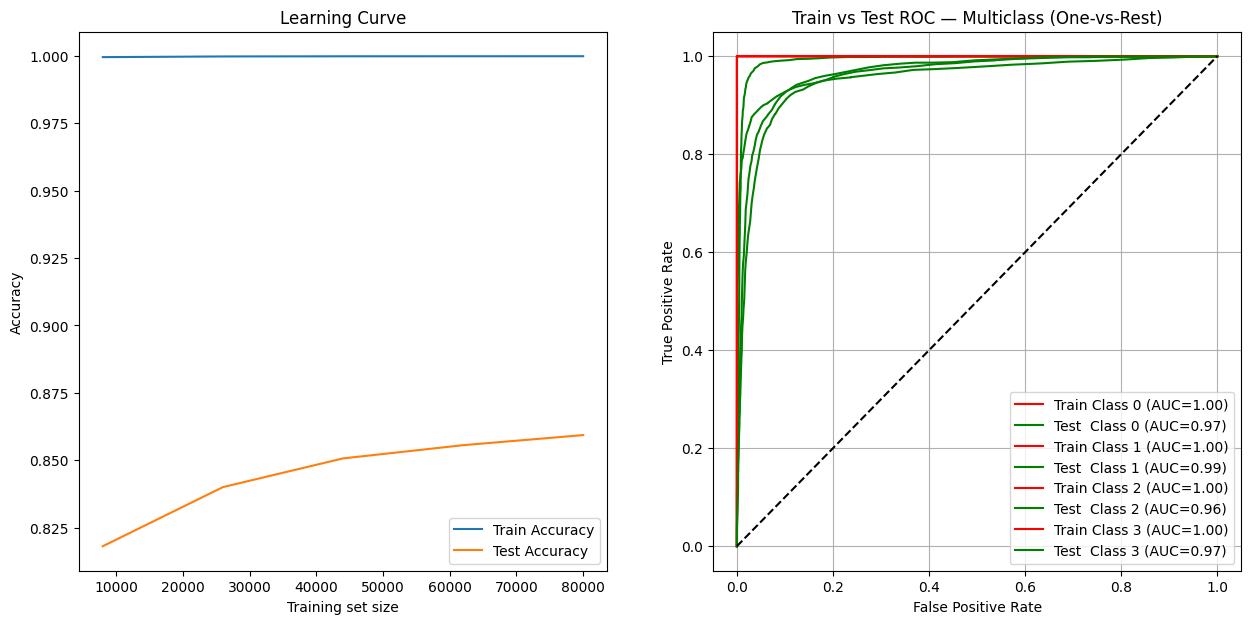

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15, 7))

#### 1.

plt.subplot(1, 2, 1)
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, 
    X_train, y_train, 
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Train Accuracy')
plt.plot(train_sizes, test_mean, label='Test Accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()

#### 2.

classes = np.unique(y_train)
n_classes = len(classes)

# Binarize train and test labels
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

# Get predicted probabilities
y_train_scores = rf_model.predict_proba(X_train)
y_test_scores  = rf_model.predict_proba(X_test)

plt.subplot(1, 2, 2)
for i in range(n_classes):
    # ROC for train
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_scores[:, i])
    auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color='red', linestyle='-', label=f"Train Class {classes[i]} (AUC={auc_train:.2f})")
    
    # ROC for test
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_scores[:, i])
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color="green", linestyle='-', label=f"Test  Class {classes[i]} (AUC={auc_test:.2f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC — Multiclass (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

##### 4.3. XGBoost

In [7]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_xgb = xgb_model.predict(X_test)

acc_list['XGBoost'] = (accuracy_score(y_test, y_pred_xgb))

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8926315789473684
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1900
           1       0.95      0.96      0.95      1900
           2       0.85      0.85      0.85      1900
           3       0.87      0.87      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



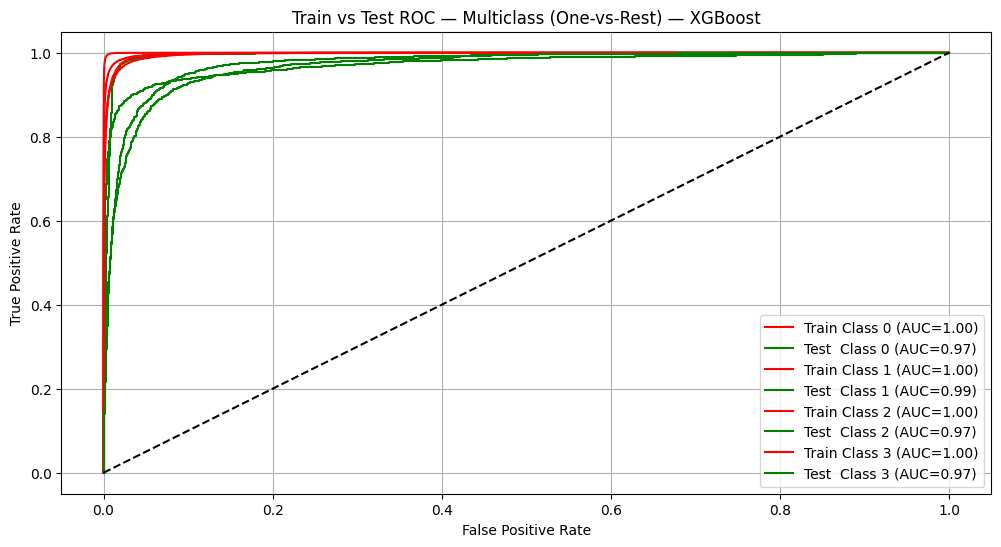

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np


classes = np.unique(y_train)
n_classes = len(classes)

# Binarize labels for One-vs-Rest ROC
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

# Predicted probabilities
y_train_proba = xgb_model.predict_proba(X_train)  # shape: (n_samples_train, n_classes)
y_test_proba  = xgb_model.predict_proba(X_test)   # shape: (n_samples_test, n_classes)

# Plot ROC for each class
plt.figure(figsize=(12, 6))

for i in range(n_classes):
    # Train ROC
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_proba[:, i])
    auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, linestyle='-', color="red", label=f"Train Class {classes[i]} (AUC={auc_train:.2f})")

    # Test ROC
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, linestyle='-', color="green", label=f"Test  Class {classes[i]} (AUC={auc_test:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC — Multiclass (One-vs-Rest) — XGBoost")
plt.legend()
plt.grid(True)
plt.show()

##### 4.4. SVM

In [8]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_svm = svm_model.predict(X_test)

acc_list['SVM'] = (accuracy_score(y_test, y_pred_svm))

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9205263157894736
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1900
           1       0.96      0.98      0.97      1900
           2       0.89      0.89      0.89      1900
           3       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



In [ ]:
from sklearn.metrics import accuracy_score

# Predictions
y_train_pred = svm_model.predict(X_train)
y_test_pred  = svm_model.predict(X_test)

# Accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_acc)
print("Testing Accuracy :", test_acc)
print("Generalization Gap:", train_acc - test_acc)

Training Accuracy: 0.9503833333333334
Testing Accuracy : 0.9205263157894736
Generalization Gap: 0.02985701754385972


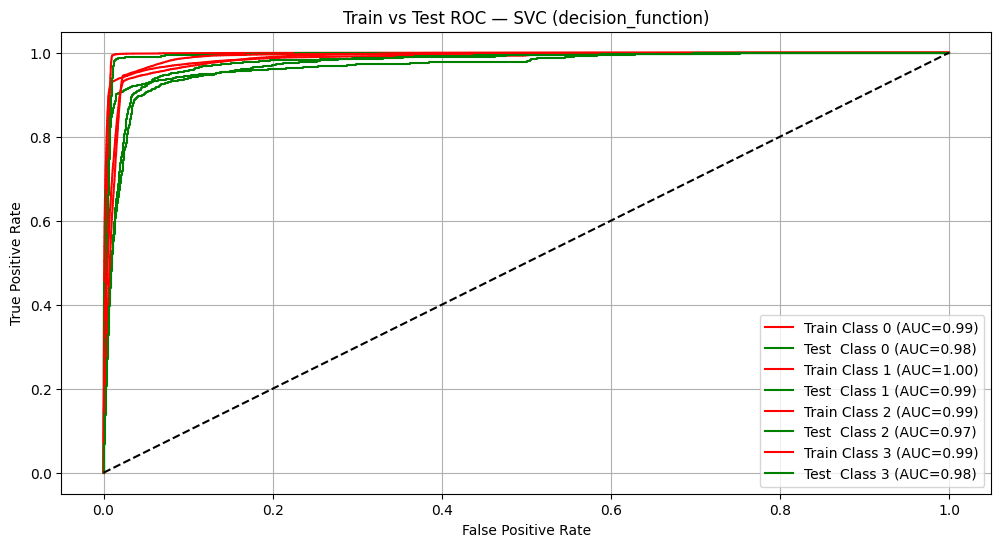

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

classes = np.unique(y_train)
n_classes = len(classes)

# Binarize labels
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

# Decision function scores
y_train_scores = svm_model.decision_function(X_train)
y_test_scores  = svm_model.decision_function(X_test)

# Plot ROC
plt.figure(figsize=(12, 6))

for i in range(n_classes):
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_scores[:, i])
    auc_train = auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_scores[:, i])
    auc_test = auc(fpr_test, tpr_test)
    
    plt.plot(fpr_train, tpr_train, linestyle='-', color='red', label=f"Train Class {classes[i]} (AUC={auc_train:.2f})")
    plt.plot(fpr_test, tpr_test, linestyle='-', color='green', label=f"Test  Class {classes[i]} (AUC={auc_test:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC — SVC (decision_function)")
plt.legend()
plt.grid(True)
plt.show()


##### 4.5. KNN

In [9]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_knn = knn_model.predict(X_test)

acc_list['KNN'] = (accuracy_score(y_test, y_pred_knn))

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.9092105263157895
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1900
           1       0.95      0.97      0.96      1900
           2       0.87      0.88      0.88      1900
           3       0.89      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



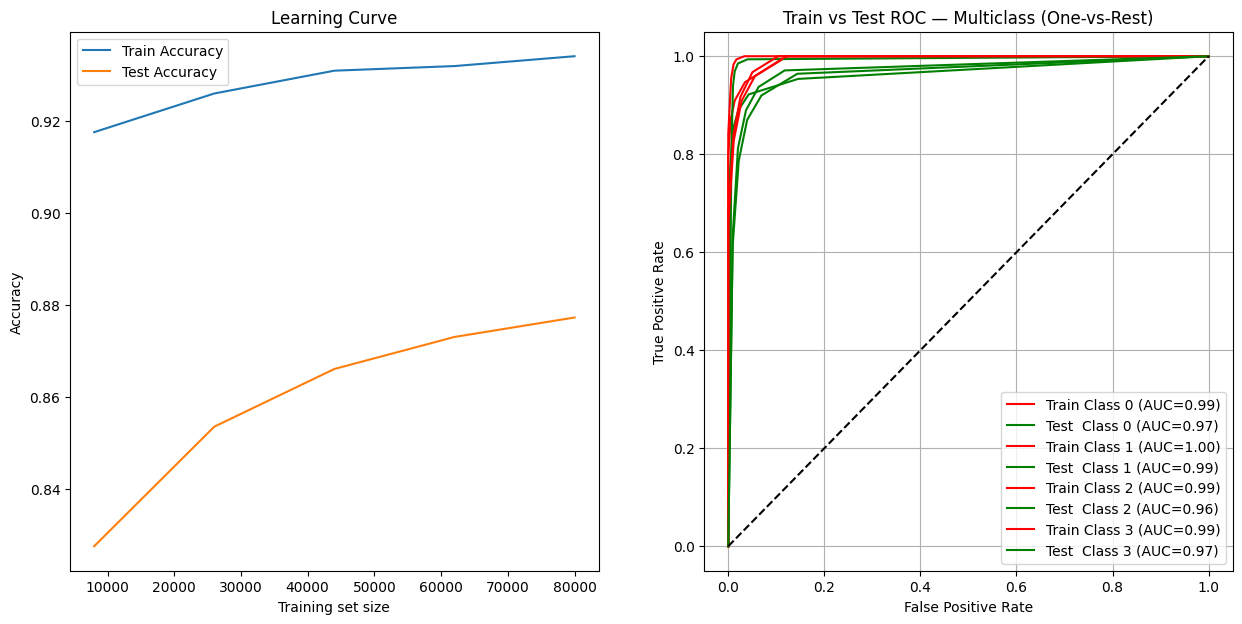

In [12]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15, 7))

#### 1.

plt.subplot(1, 2, 1)
train_sizes, train_scores, test_scores = learning_curve(
    knn_model, 
    X_train, y_train, 
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Train Accuracy')
plt.plot(train_sizes, test_mean, label='Test Accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()

classes = np.unique(y_train)
n_classes = len(classes)

# Binarize train and test labels
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin  = label_binarize(y_test, classes=classes)

# Get predicted probabilities
y_train_scores = knn_model.predict_proba(X_train)
y_test_scores  = knn_model.predict_proba(X_test)

#### 2.

plt.subplot(1, 2, 2)
for i in range(n_classes):
    # ROC for train
    fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_scores[:, i])
    auc_train = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, color='red', linestyle='-', label=f"Train Class {classes[i]} (AUC={auc_train:.2f})")
    
    # ROC for test
    fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_scores[:, i])
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color="green", linestyle='-', label=f"Test  Class {classes[i]} (AUC={auc_test:.2f})")


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train vs Test ROC — Multiclass (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

##### 4.6. Grouper les resultats

In [10]:
import pandas as pd

acc_df = pd.DataFrame(acc_list.values(), index=acc_list.keys(), columns=['Accuracy'])

acc_df.sort_values(by='Accuracy', ascending=False)

,Accuracy
SVM,0.920526
KNN,0.909211
XGBoost,0.892632
Logistic Regression,0.888289
Random Forest,0.880921
